# Sparkify Project Workspace
This workspace contains a tiny subset (128MB) of the full dataset available (12GB). Feel free to use this workspace to build your project, or to explore a smaller subset with Spark before deploying your cluster on the cloud. Instructions for setting up your Spark cluster is included in the last lesson of the Extracurricular Spark Course content.

You can follow the steps below to guide your data analysis and model building portion of this project.

# Spark Project: Sparkify

The aim of the project is to build a machine pipeline to predict churn rate. Predicting churn rates is a challenging and common problem that data scientists and analysts regularly encounter in any customer-facing business.

In [1]:
# import libraries
from pyspark.sql import SparkSession
from pyspark.sql.types import IntegerType, StringType
from pyspark.sql.window import Window

from pyspark.ml import Pipeline
from pyspark.ml.feature import MinMaxScaler, VectorAssembler
from pyspark.ml.classification import LogisticRegression, RandomForestClassifier, GBTClassifier
from pyspark.ml.evaluation import BinaryClassificationEvaluator, MulticlassClassificationEvaluator
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.ml.feature import StandardScaler

import pyspark.sql.functions as F
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

In [2]:
# create a Spark session
spark = SparkSession.builder.appName("Sparkify").getOrCreate()

# Load and Clean Dataset
In this workspace, the mini-dataset file is `mini_sparkify_event_data.json`. Load and clean the dataset, checking for invalid or missing data - for example, records without userids or sessionids. 

In [3]:
#event_data = "./mini_sparkify_event_data.json"
event_data = "./medium-sparkify-event-data.json"
df = spark.read.json(event_data)
df.head()

Row(artist='Martin Orford', auth='Logged In', firstName='Joseph', gender='M', itemInSession=20, lastName='Morales', length=597.55057, level='free', location='Corpus Christi, TX', method='PUT', page='NextSong', registration=1532063507000, sessionId=292, song='Grand Designs', status=200, ts=1538352011000, userAgent='"Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_4) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/36.0.1985.125 Safari/537.36"', userId='293')

# Exploratory Data Analysis
When you're working with the full dataset, perform EDA by loading a small subset of the data and doing basic manipulations within Spark. In this workspace, you are already provided a small subset of data you can explore.

### Define Churn

Once you've done some preliminary analysis, create a column `Churn` to use as the label for your model. I suggest using the `Cancellation Confirmation` events to define your churn, which happen for both paid and free users. As a bonus task, you can also look into the `Downgrade` events.

### Explore Data
Once you've defined churn, perform some exploratory data analysis to observe the behavior for users who stayed vs users who churned. You can start by exploring aggregates on these two groups of users, observing how much of a specific action they experienced per a certain time unit or number of songs played.

### schema and statistics on the data

In [4]:
# print the schema to understand the dataset
df.printSchema()

root
 |-- artist: string (nullable = true)
 |-- auth: string (nullable = true)
 |-- firstName: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- itemInSession: long (nullable = true)
 |-- lastName: string (nullable = true)
 |-- length: double (nullable = true)
 |-- level: string (nullable = true)
 |-- location: string (nullable = true)
 |-- method: string (nullable = true)
 |-- page: string (nullable = true)
 |-- registration: long (nullable = true)
 |-- sessionId: long (nullable = true)
 |-- song: string (nullable = true)
 |-- status: long (nullable = true)
 |-- ts: long (nullable = true)
 |-- userAgent: string (nullable = true)
 |-- userId: string (nullable = true)



In [5]:
df.describe().show()
#it appears there are null values in the dataset

+-------+-----------------+----------+---------+------+------------------+--------+-----------------+------+----------------+------+-------+--------------------+------------------+--------------------+------------------+--------------------+--------------------+------------------+
|summary|           artist|      auth|firstName|gender|     itemInSession|lastName|           length| level|        location|method|   page|        registration|         sessionId|                song|            status|                  ts|           userAgent|            userId|
+-------+-----------------+----------+---------+------+------------------+--------+-----------------+------+----------------+------+-------+--------------------+------------------+--------------------+------------------+--------------------+--------------------+------------------+
|  count|           432877|    543705|   528005|528005|            543705|  528005|           432877|543705|          528005|543705| 543705|              

In [6]:
# which features has missing values
def print_missing_value(df, col):
    """
    print the percentage of missing values in a column, and number of unique values
    Args:
        df  - dataframe
        col - column name
    Returns:
        None
    """
    count = df.filter((F.isnan(df[col])) | (df[col].isNull()) | (df[col] == '')).count()
    if count > 0:
       print (f'{col} has {count}, {count/df.count():.2%}% missing values, and {df.select(col).distinct().count()} distinct values')
    else:
        print (f'{col} has 0, 0.00% missing values, and {df.select(col).distinct().count()} distinct values')
        
for col in df.columns:
    # check if column contains NaN, '' or Null value
    print_missing_value(df, col)

artist has 110828, 20.38%% missing values, and 21248 distinct values
auth has 0, 0.00% missing values, and 4 distinct values
firstName has 15700, 2.89%% missing values, and 346 distinct values
gender has 15700, 2.89%% missing values, and 3 distinct values
itemInSession has 0, 0.00% missing values, and 1006 distinct values
lastName has 15700, 2.89%% missing values, and 276 distinct values
length has 110828, 20.38%% missing values, and 16680 distinct values
level has 0, 0.00% missing values, and 2 distinct values
location has 15700, 2.89%% missing values, and 193 distinct values
method has 0, 0.00% missing values, and 2 distinct values
page has 0, 0.00% missing values, and 22 distinct values
registration has 15700, 2.89%% missing values, and 449 distinct values
sessionId has 0, 0.00% missing values, and 4590 distinct values
song has 110828, 20.38%% missing values, and 80293 distinct values
status has 0, 0.00% missing values, and 3 distinct values
ts has 0, 0.00% missing values, and 51310

In [7]:
#sample distinct value for selected columns
for col in ['auth', 'gender', 'level', 'method', 'page', 'status']:
    print (f'feature {col} has the following distinct values: {df.select(df[col]).distinct().collect()}')


feature auth has the following distinct values: [Row(auth='Logged Out'), Row(auth='Cancelled'), Row(auth='Guest'), Row(auth='Logged In')]
feature gender has the following distinct values: [Row(gender='F'), Row(gender=None), Row(gender='M')]
feature level has the following distinct values: [Row(level='free'), Row(level='paid')]
feature method has the following distinct values: [Row(method='PUT'), Row(method='GET')]
feature page has the following distinct values: [Row(page='Cancel'), Row(page='Submit Downgrade'), Row(page='Thumbs Down'), Row(page='Home'), Row(page='Downgrade'), Row(page='Roll Advert'), Row(page='Logout'), Row(page='Save Settings'), Row(page='Cancellation Confirmation'), Row(page='About'), Row(page='Submit Registration'), Row(page='Settings'), Row(page='Login'), Row(page='Register'), Row(page='Add to Playlist'), Row(page='Add Friend'), Row(page='NextSong'), Row(page='Thumbs Up'), Row(page='Help'), Row(page='Upgrade'), Row(page='Error'), Row(page='Submit Upgrade')]
feature

In [8]:
#method column seems to be redundant, each page can be retrieve either by get or put, not both. so
#method column depends on the page column
print (f"number of unique page value: {df[['page']].distinct().count()}, vs number of unique page,method combination: {df[['method', 'page']].distinct().count()} ")
df[['method', 'page']].distinct().collect()

number of unique page value: 22, vs number of unique page,method combination: 22 


[Row(method='PUT', page='Cancel'),
 Row(method='PUT', page='Logout'),
 Row(method='PUT', page='Add to Playlist'),
 Row(method='GET', page='Downgrade'),
 Row(method='PUT', page='Submit Registration'),
 Row(method='PUT', page='Submit Upgrade'),
 Row(method='PUT', page='Thumbs Up'),
 Row(method='GET', page='Home'),
 Row(method='PUT', page='Add Friend'),
 Row(method='GET', page='Error'),
 Row(method='GET', page='Upgrade'),
 Row(method='PUT', page='Thumbs Down'),
 Row(method='PUT', page='Save Settings'),
 Row(method='GET', page='Help'),
 Row(method='GET', page='Settings'),
 Row(method='PUT', page='Submit Downgrade'),
 Row(method='GET', page='Cancellation Confirmation'),
 Row(method='GET', page='Register'),
 Row(method='PUT', page='Login'),
 Row(method='GET', page='Roll Advert'),
 Row(method='GET', page='About'),
 Row(method='PUT', page='NextSong')]

In [9]:
#handle missing values, if any of userid is missing  drop the record.
def handle_missing_data(df):
    """
    handle missing values, if any of the userid is missing, drop the record
    Args:
        df - dataframe to be processed
    Returns:
        Data Frame with missing values in UserId removed
    """
    df = df.dropna(subset=['userId', 'sessionId'], how='any')
    return df.where(df['userId'] != "")

df = handle_missing_data(df)

In [10]:
#number of unique users
print (f"number of unique userid: {df[['userId']].distinct().count()}")

number of unique userid: 448


<Figure size 576x432 with 0 Axes>

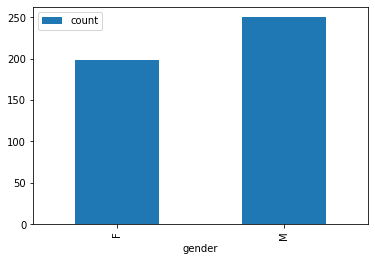

In [11]:
#check to see the distribution of user by gender
plt.figure(figsize=(8,6))
gender_by_level = df[['userId', 'gender']].distinct().groupby('gender').count().toPandas()
gender_by_level.set_index('gender').plot(kind='bar')

In [12]:
# number of records in dataframe, this is sample with missing value in userid, sessionid removed
print (f'number of rows in the data set: {df.count()}')

number of rows in the data set: 528005


## define churn column

churn is defined as when page == 'Cancellation Confirmation'

In [13]:
bool_to_int = F.udf(lambda x: 1 if x else 0, IntegerType()) #convert boolean to int
def add_churn_column(df):
    """
    add a churn column to the dataframe, churn column is 1 is any of the page for a user is Cancellation Confirmation
    Args:
        df - dataframe
    Returns
        new dataframe with churn column added
    """
    userlist = df.where(df.page == 'Cancellation Confirmation').select(F.col('userId')).rdd.flatMap(lambda x: x).collect()
    return df.withColumn('churn', bool_to_int(df.userId.isin(userlist)))

df_churned = add_churn_column(df)
df_churned[['userId', 'churn']].groupby('userId').max().select(F.avg('max(churn)').alias('churn rate')).show()

+-------------------+
|         churn rate|
+-------------------+
|0.22098214285714285|
+-------------------+



### gender distribution by churn

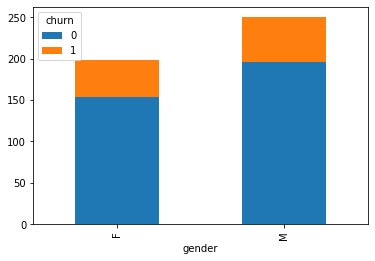

In [14]:
churn_by_gender = df_churned[['userId', 'gender', 'churn']].groupby(['userId', 'gender']). \
                     max().groupby(['gender', 'max(churn)']).count().toPandas()
churn_by_gender.rename(columns={'max(churn)' : 'churn'}).pivot(index='gender', columns='churn', values = 'count'). \
                       plot(kind='bar', stacked = True);

### level distribution by churn

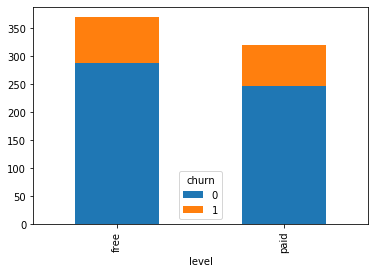

In [15]:
churn_by_level = df_churned[['userId', 'level', 'churn']].groupby(['userId', 'level']). \
                     max().groupby(['level', 'max(churn)']).count().toPandas()
churn_by_level.rename(columns={'max(churn)' : 'churn'}).pivot(index='level', columns='churn', values = 'count').plot(kind='bar', stacked = True);

### page distribution by churn

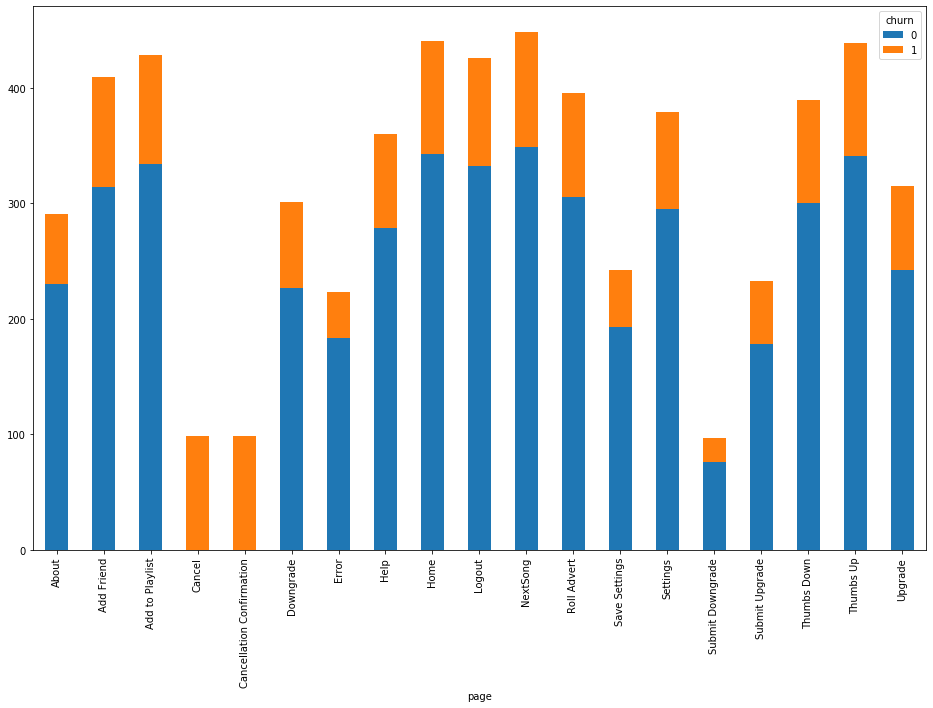

In [16]:
plt.rcParams["figure.figsize"] = (16,10)
churn_by_page = df_churned[['userId', 'page', 'churn']].groupby(['userId', 'page']). \
                     agg(F.max('churn').alias('churn')).groupby(['churn', 'page']).count().toPandas()
churn_pivot = churn_by_page.pivot(index='page', columns='churn', values='count').fillna(0.0)
churn_pivot.plot(kind='bar', stacked=True)
#churn_by_page.pivot(index='page', columns='sum(churn)', values='count').plot(kind='bar', stacked=True)

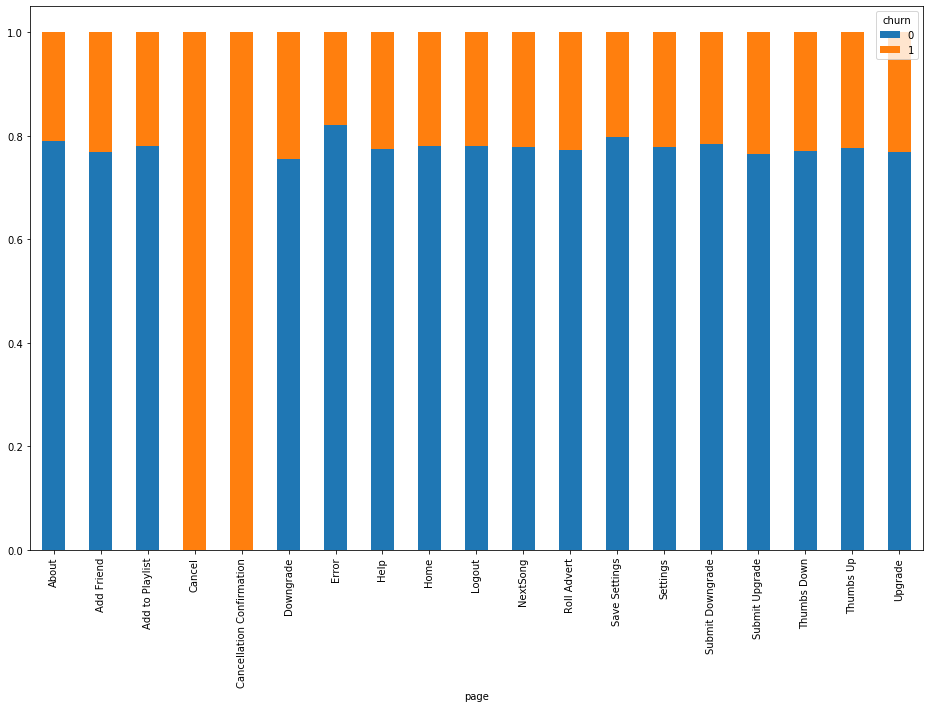

In [17]:
churn_pivot.div(churn_pivot.sum(1).astype(float), axis=0).plot(kind='bar', stacked=True)

### add is male and is paid column

In [18]:
#convert gender and level to 1 or 0
is_male = F.udf(lambda x: 1 if x == 'M' else 0, IntegerType())
is_paid = F.udf(lambda x: 1 if x == 'paid' else 0, IntegerType())

df_churned = df_churned.withColumn("male", is_male("gender"))
df_churned = df_churned.withColumn("paid", is_paid("level"))

# Feature Engineering
Once you've familiarized yourself with the data, build out the features you find promising to train your model on. To work with the full dataset, you can follow the following steps.
- Write a script to extract the necessary features from the smaller subset of data
- Ensure that your script is scalable, using the best practices discussed in Lesson 3
- Try your script on the full data set, debugging your script if necessary

If you are working in the classroom workspace, you can just extract features based on the small subset of data contained here. Be sure to transfer over this work to the larger dataset when you work on your Spark cluster.

In [19]:
entire_window = Window.partitionBy('userId').orderBy(F.desc('ts'))    
df_churned = df_churned.withColumn("last_is_paid", F.first("paid").over(entire_window))

In [20]:
#calculate membership lifetime, it is calculated as max timestamp - registration time, in terms of days
df_churned = df_churned.withColumn('lifetime', (F.col('ts') - F.col('registration'))/(60*60*24*1000))

In [21]:
df_features = df_churned.groupby("userId").agg(
    F.max("churn").alias("churn"),
    F.max("male").alias("male"),
    F.max("last_is_paid").alias("last_is_paid"),
    F.max(F.when(F.col("page") == "Submit Upgrade", 1).otherwise(0)).alias("upgrade"),
    F.max(F.when(F.col("page") == "Submit Downgrade", 1).otherwise(0)).alias("downgrade"),
    F.sum(F.when(F.col("page") == "Thumbs Up", 1).otherwise(0)).alias("thumbsup"),
    F.sum(F.when(F.col("page") == "Thumbs Down", 1).otherwise(0)).alias("thumbsdown"),
    F.sum(F.when(F.col("page") == "Error", 1).otherwise(0)).alias("error"),
    F.sum(F.when(F.col("page") == "Help", 1).otherwise(0)).alias("help"),
    F.sum(F.when(F.col("page")=="Add Firend", 1).otherwise(0)).alias("friend"),
    F.sum(F.when(F.col("page")=="Add to Playlist", 1).otherwise(0)).alias("playlist"),
    F.max("lifetime").alias("lifetime"),
    F.avg("length").alias("songlength"),
    F.avg("itemInSession").alias("avgItemInSession"),
    F.countDistinct("Artist").alias("artist"),
    F.countDistinct("sessionId").alias("session"),
    F.countDistinct("userAgent").alias("agents"),
    F.countDistinct("location").alias("location"),
    F.countDistinct("song").alias('songcount'),
)
df_features.head()

Row(userId='100010', churn=1, male=0, last_is_paid=0, upgrade=0, downgrade=0, thumbsup=4, thumbsdown=3, error=0, help=0, friend=0, playlist=1, lifetime=14.328449074074074, songlength=269.48907020833326, avgItemInSession=33.839416058394164, artist=94, session=2, agents=1, location=1, songcount=96)

In [22]:
df_features.toPandas()

,userId,churn,male,last_is_paid,upgrade,downgrade,thumbsup,thumbsdown,error,help,friend,playlist,lifetime,songlength,avgItemInSession,artist,session,agents,location,songcount
0,100010,1,0,0,0,0,4,3,0,0,0,1,14.328449,269.489070,33.839416,94,2,1,1,96
1,200002,1,1,1,1,0,15,5,0,1,0,6,53.323148,253.857506,54.832911,287,5,1,1,306
2,296,1,0,1,1,0,8,0,0,2,0,3,26.638264,252.804911,27.644737,108,5,1,1,109
3,125,0,1,0,0,0,3,1,0,2,0,2,105.422118,255.060824,27.297619,61,3,1,1,62
4,124,1,0,1,0,0,102,15,0,10,0,45,112.553796,250.089836,126.100649,1240,17,1,1,1611
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
443,216,0,0,0,1,1,80,15,2,12,0,52,115.490197,251.531113,82.172211,1204,20,1,1,1537
444,119,0,0,0,0,0,12,4,0,2,0,17,192.793310,249.802732,41.702186,250,8,1,1,269
445,100001,1,0,0,0,0,5,1,0,1,0,3,44.726771,247.868118,27.902985,93,3,1,1,96
446,300029,0,1,1,1,0,39,3,0,0,0,13,65.667604,248.718972,53.845316,314,7,1,1,342


# Modeling
Split the full dataset into train, test, and validation sets. Test out several of the machine learning methods you learned. Evaluate the accuracy of the various models, tuning parameters as necessary. Determine your winning model based on test accuracy and report results on the validation set. Since the churned users are a fairly small subset, I suggest using F1 score as the metric to optimize.

### split data into train and test set

In [23]:
train, test = df_features.randomSplit([0.8, 0.2], seed=42)

In [24]:
feature_columns = [ col for col in df_features.columns if col != 'churn' and col != 'userId']
print (feature_columns)

['male', 'last_is_paid', 'upgrade', 'downgrade', 'thumbsup', 'thumbsdown', 'error', 'help', 'friend', 'playlist', 'lifetime', 'songlength', 'avgItemInSession', 'artist', 'session', 'agents', 'location', 'songcount']


In [25]:
def build_model(classifier, params):
    """
    build the pipeline to create the model
    Args:
        classifier : model used to classify
        params     : params to be tuned
    Returns:
        pipeline for the process
    """
    assembler = VectorAssembler(inputCols=['lifetime', 'songlength', 'avgItemInSession', 'artist',
                                          'session', 'agents', 'location', 'songcount'], outputCol="numeric_features")
    scaler = StandardScaler(inputCol='numeric_features', outputCol='normalized_features', withMean=True, withStd=True)
    feature_assembler = VectorAssembler(inputCols=['normalized_features', 'male', 'last_is_paid', 'upgrade', 'downgrade',
                                                   'thumbsup', 'thumbsdown', 'error', 'help', 'friend', 'playlist'],
                                        outputCol='features')
    pipeline = Pipeline(stages = [ assembler, scaler, feature_assembler, classifier])
    
    model = CrossValidator(
        estimator = pipeline,
        estimatorParamMaps = params,
        evaluator = MulticlassClassificationEvaluator(labelCol='churn', metricName='f1'),
        numFolds=5,
    )
    return model

In [51]:
### function to evaluate metrics
def evaluate_model(predictions):
    """
        returns the metrics for the predictions
        Args:
            predictions - predictions by the model
        Returns:
            accuracy - accuracy of the predictions
            f1       - f1 metrics of the predictions
            recall   - recall metrics of the predictions
            precision - precision metrics of the predictions
    """
    evaluator = MulticlassClassificationEvaluator(labelCol="churn", predictionCol="prediction", metricName="f1")
    accuracy = evaluator.evaluate(predictions, {evaluator.metricName: 'accuracy'})
    f1 = evaluator.evaluate(predictions, {evaluator.metricName: 'f1'})
    recall = evaluator.evaluate(predictions, {evaluator.metricName: 'weightedRecall'})
    precision = evaluator.evaluate(predictions, {evaluator.metricName: 'weightedPrecision'})
        
    return accuracy, f1, recall, precision
    

In [ ]:
    binary_evaluator = BinaryClassificationEvaluator(labelCol="churn")
    auroc = binary_evaluator.evaluate(predictions, {binary_evaluator.metricName: 'areaUnderROC'})
    pr_recall = binary_evaluator.evaluate(predictions, {binary_evaluator.metricName: 'areaUnderPR'})


### logistic regression

In [27]:
lr = LogisticRegression(featuresCol="features", labelCol="churn", maxIter=10)
params = ParamGridBuilder().addGrid(lr.regParam,[0.3, 0.5, 0.8]) \
                           .addGrid(lr.elasticNetParam,[0.8, 1]) \
                           .build()
lr_model = build_model(lr, params)

In [28]:
lr_fit_model = lr_model.fit(train)

In [29]:
lr_pred = lr_fit_model.transform(test)

In [52]:
lr_accuracy, lr_f1, lr_recall, lr_precision = evaluate_model(lr_pred)
print ('Logistic Regression')
print ('accuracy: {}'.format(lr_accuracy))
print ('f1: {}'.format(lr_f1))
print ('weighted recall: {}'.format(lr_recall))
print ('weighted precision: {}'.format(lr_precision))


Logistic Regression
accuracy: 0.8604651162790697
f1: 0.7959302325581394
weighted recall: 0.8604651162790697
weighted precision: 0.740400216333153


In [55]:
binary_evaluator = BinaryClassificationEvaluator(labelCol="churn")
auroc = binary_evaluator.evaluate(lr_pred, {binary_evaluator.metricName: 'areaUnderROC'})
pr_recall = binary_evaluator.evaluate(lr_pred, {binary_evaluator.metricName: 'areaUnderPR'})

print ('Area Under ROC: {}, Precision-Recall: {}'.format(auroc, pr_recall))

Area Under ROC: 0.5, Precision-Recall: 0.13953488372093023


### Random Forest

In [32]:
rf = RandomForestClassifier(featuresCol="features", labelCol="churn")
params = ParamGridBuilder().addGrid(rf.maxDepth, [2,5,10]) \
                           .addGrid(rf.numTrees, [5,20,50]) \
                           .addGrid(rf.maxBins, [5,10,20]) \
                           .build()
rf_model = build_model(rf, params)

In [33]:
rf_fit_model = rf_model.fit(train)
rf_pred = rf_fit_model.transform(test)

In [53]:
rf_accuracy, rf_f1, rf_recall, rf_precision = evaluate_model(rf_pred)
print ('Random Forest')
print ('accuracy: {}'.format(rf_accuracy))
print ('f1: {}'.format(rf_f1))
print ('weighted recall: {}'.format(rf_recall))
print ('weighted precision: {}'.format(rf_precision))

Random Forest
accuracy: 0.8604651162790697
f1: 0.8483476132190944
weighted recall: 0.8604651162790697
weighted precision: 0.8419797257006559


In [56]:
binary_evaluator = BinaryClassificationEvaluator(labelCol="churn")
auroc = binary_evaluator.evaluate(rf_pred, {binary_evaluator.metricName: 'areaUnderROC'})
pr_recall = binary_evaluator.evaluate(rf_pred, {binary_evaluator.metricName: 'areaUnderPR'})

print ('Area Under ROC: {}, Precision-Recall: {}'.format(auroc, pr_recall))

Area Under ROC: 0.6914414414414413, Precision-Recall: 0.4663619419580238


### Gradient Boost

In [36]:
gbt = GBTClassifier(featuresCol='features', labelCol='churn')
params = ParamGridBuilder().addGrid(gbt.maxDepth, [2,5,10]) \
                           .addGrid(gbt.maxBins, [5,10,20]) \
                           .build()
gbt_model = build_model(gbt, params)

In [37]:
gbt_fit_model = gbt_model.fit(train)
gbt_pred = gbt_fit_model.transform(test)

In [54]:
gbt_accuracy, gbt_f1, gbt_recall, gbt_precision = evaluate_model(gbt_pred)
print ('Gradient Boosting')
print ('accuracy: {}'.format(gbt_accuracy))
print ('f1: {}'.format(gbt_f1))
print ('weighted recall: {}'.format(gbt_recall))
print ('weighted precision: {}'.format(gbt_precision))


Gradient Boosting
accuracy: 0.8953488372093024
f1: 0.8832889336885303
weighted recall: 0.8953488372093024
weighted precision: 0.8838891458850247


In [57]:
binary_evaluator = BinaryClassificationEvaluator(labelCol="churn")
auroc = binary_evaluator.evaluate(gbt_pred, {binary_evaluator.metricName: 'areaUnderROC'})
pr_recall = binary_evaluator.evaluate(gbt_pred, {binary_evaluator.metricName: 'areaUnderPR'})

print ('Area Under ROC: {}, Precision-Recall: {}'.format(auroc, pr_recall))

Area Under ROC: 0.6649774774774777, Precision-Recall: 0.49614258970259423


## Feature Importances

In [92]:
#show the importance features for tree based model
def show_importances(feature_col, model):
    """
    show the important features for tree based model
    Args:
         feature_col - feature column
         model - model
    Returns:
         df - dataframe containing the features sorted by importances
    """
    
    df = pd.DataFrame({'feature' : ['lifetime', 'songlength', 'avgItemInSession', 'artist', 'session', 'agents', 'location', 'songcount',
                                    'male', 'last_is_paid', 'upgrade', 'downgrade',
                                    'thumbsup', 'thumbsdown', 'error', 'help', 'friend', 'playlist'],
                       'importance' : model.bestModel.stages[3].featureImportances.toArray()
                      })
    df = df.sort_values(by='importance', ascending=False).reset_index(drop=True)
    return df

In [95]:
#Gradient Boosting
importance_df = show_importances(feature_col, gbt_fit_model)
importance_df

,feature,importance
0,thumbsup,0.202439
1,avgItemInSession,0.165014
2,playlist,0.145186
3,lifetime,0.102796
4,thumbsdown,0.080500
5,session,0.070074
6,help,0.063465
7,error,0.058656
8,last_is_paid,0.045247
9,songlength,0.031223


(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17]),
 <a list of 18 Text xticklabel objects>)

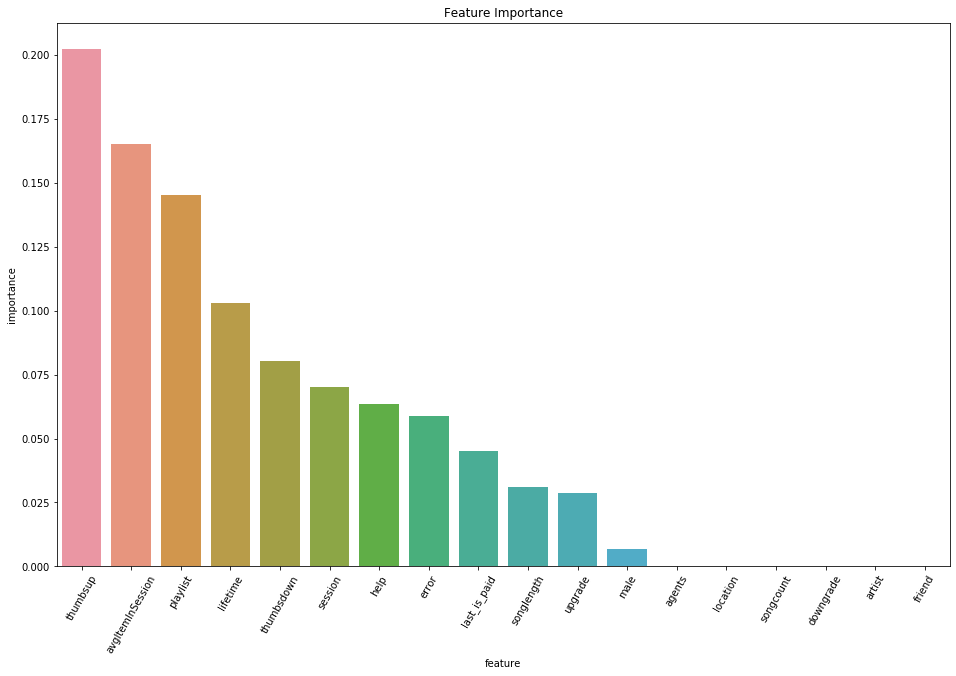

In [99]:
sns.barplot(x='feature', y='importance', data=importance_df)
plt.title('Feature Importance')
plt.xticks(rotation=60)

# Final Steps
Clean up your code, adding comments and renaming variables to make the code easier to read and maintain. Refer to the Spark Project Overview page and Data Scientist Capstone Project Rubric to make sure you are including all components of the capstone project and meet all expectations. Remember, this includes thorough documentation in a README file in a Github repository, as well as a web app or blog post.

### conclusion

As our data is imbalance, the churn percentage is only 20% of the sample. F1 score will be a more appropriate metri than Accuracy or Area Under ROC metric. In fact, if we have a dummy model that always predict user will not cancel the service, it will achieve an accuracy of 80% which is not so bad, so looking at accuracy alone will not tell the whole story.

Based on the F1 score for each model, Gradient Boosting will be the best model to predict the churn rate.
